# Clase 4: Autocorrelaciones espaciales en Python

En este ejercicio, analizaremos la distribución espacial de inmigrantes en la ciudad de Santiago, en base a los datos del Censo 2017 agrupados por zona censal.

En particular, analizaremos si hay autocorrelación espacial en la distribución de inmigrantes. Es decir, ¿cuál es el el nivel de similaridad entre la cantidad de inmigrantes en distintas zonas? ¿Los valores en general siguen algún patrón espacial en cuanto a su distribución geográfica, o están distribuidos aleatoriamente en el espacio?

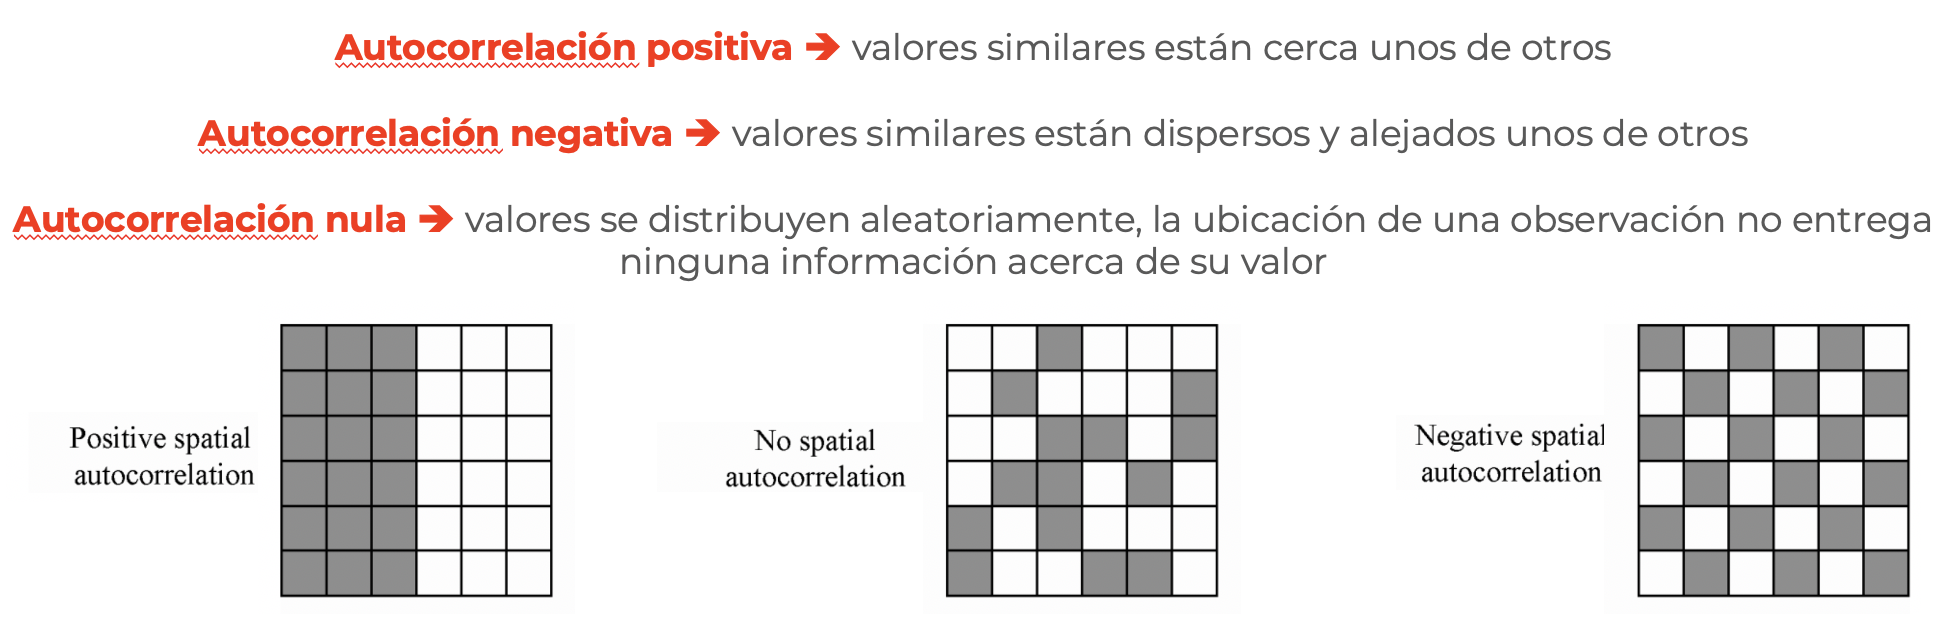



## Importación de librerías

Para instalar PySAL, ver: https://pysal.org/install

- Installing PySAL via Conda

`conda install --channel conda-forge pysal`

- Install PySAL via pip

`pip install pysal`

In [1]:
%matplotlib inline

import seaborn as sns
import pandas as pd
import pysal as ps
from pysal.lib import weights
from pysal.explore import esda
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt


/Users/paguirre/anaconda3/lib/python3.6/site-packages/pysal/__init__.py:65: VisibleDeprecationWarning: PySAL's API will be changed on 2018-12-31. The last release made with this API is version 1.14.4. A preview of the next API version is provided in the `pysalnext` package. The API changes and a guide on how to change imports is provided at https://migrating.pysal.org
  ), VisibleDeprecationWarning)
/Users/paguirre/anaconda3/lib/python3.6/site-packages/numba/decorators.py:29: NumbaDeprecationWarning: autojit is deprecated, use jit instead, which provides the same functionality. For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-numba-autojit
  warnings.warn(NumbaDeprecationWarning(msg))


## Datos.

Los datos para este ejercicio corresponden a un resumen de los datos del censo 2017 para la región Metropolitana. Para cada zona censal, se incluyen los datos agregados del total de personas, número de hombres y mujeres, número de inmigrantes, número de adultos mayores (65 años o más), y cantidad de personas pertenecientes a pueblos originarios.

In [2]:
zona_diss=gpd.read_file('datosZonas_Stgo_C2017.gpkg')
print(zona_diss.columns)

Index(['NZONA', 'EDAD_65YMA', 'INMIGRANTE', 'PERSONAS', 'HOMBRES', 'MUJERES',
       'PUEBLO', 'geometry'],
      dtype='object')


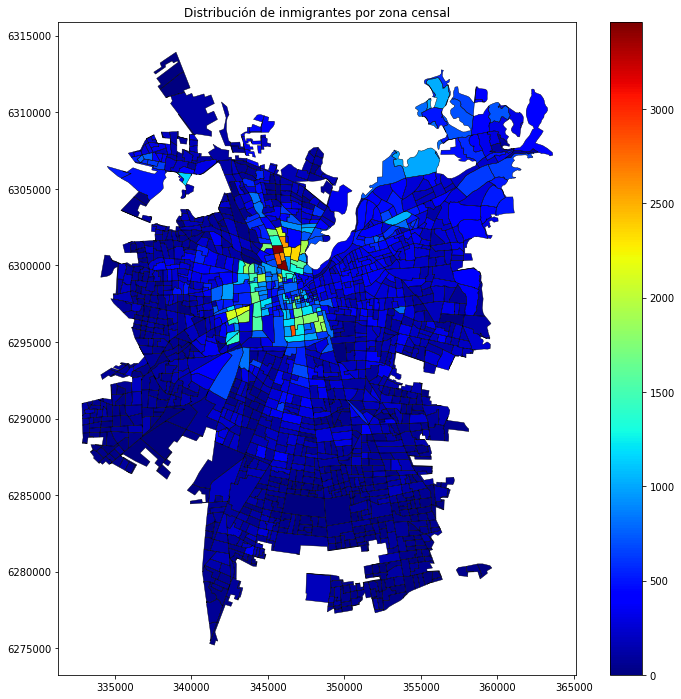

In [3]:
f, ax = plt.subplots(1, figsize=(12,12))
field_correl='INMIGRANTE'

zona_diss.plot(ax=ax, column=field_correl,cmap='jet', linewidth=0.4,legend=True)
zona_diss.boundary.plot(ax=ax, color='black',linewidth=0.4,label='Zonas')
ax.set_title('Distribución de inmigrantes por zona censal');

In [4]:
print(zona_diss.shape)
print(zona_diss.head())

(1617, 8)
   NZONA  EDAD_65YMA  INMIGRANTE  PERSONAS  HOMBRES  MUJERES  PUEBLO  \
0      0           4          11        78       39       16       7   
1      1           0           0        57       26       16       4   
2      2         473          40      5780     2842     2938     870   
3      3         264         204      1903      948      955     176   
4      4         202          74      1119      537      582     105   

                                            geometry  
0  POLYGON ((339574.260 6311305.663, 339538.435 6...  
1  POLYGON ((339518.173 6312645.500, 339520.213 6...  
2  POLYGON ((347665.806 6284980.600, 347660.588 6...  
3  POLYGON ((346162.023 6294431.152, 346158.444 6...  
4  POLYGON ((350402.037 6291193.798, 350404.637 6...  


## Matrices de pesos espaciales.

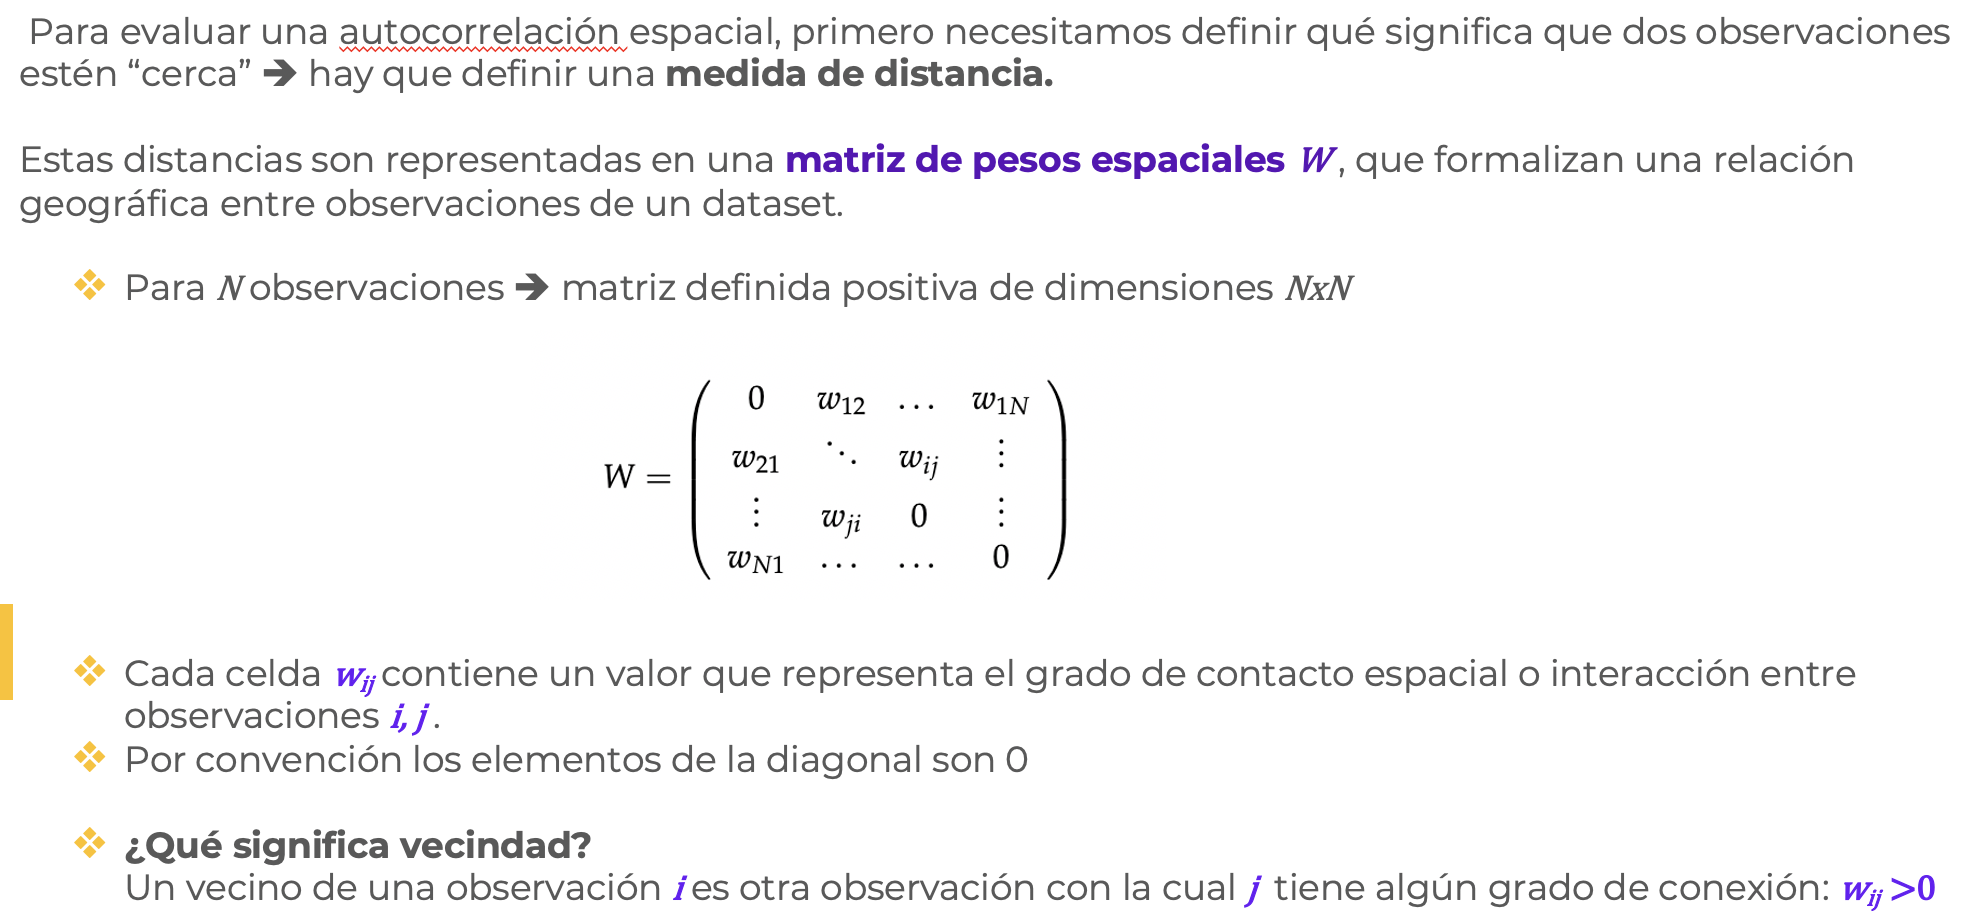


#### Como vimos en clases, hay distintas formas de definir una matriz de peso espacial:

- Matrices de contiguidad: definen conexiones espaciales a partir la existencia de fronteras comunes. Ej: Queen y Rook.

- Matrices de distancia: asignan pesos a cada par de observaciones en base a la distancia dij entre los centroides de las unidades espaciales i, j. Hay distintas formas para convertir distancia en pesos, puede ser binario (ej: k-nearest neighbours) o continuo.

El cálculo de distintos tipos de matrices de pesos espaciales está implementado en la librería `weights`de PySAL:

https://pysal.org/libpysal/api.html



In [5]:
print('Queen')
w_queen = weights.Queen.from_dataframe(zona_diss,idVariable='NZONA')
print('Rook')
w_rook = weights.Rook.from_dataframe(zona_diss,idVariable='NZONA')
print('KNN')
w_knn = weights.KNN.from_dataframe(zona_diss,k=3,ids='NZONA')
print('Distance')
w_dist_1km = weights.DistanceBand.from_dataframe(zona_diss, 1000)
print(zona_diss.crs)
print(w_dist_1km)

Queen


/Users/paguirre/anaconda3/lib/python3.6/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


Rook
KNN
Distance
epsg:32719


/Users/paguirre/anaconda3/lib/python3.6/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 37 disconnected components.
 There are 25 islands with ids: 0, 1, 130, 158, 273, 281, 284, 627, 630, 636, 731, 732, 741, 745, 747, 749, 874, 894, 908, 1222, 1247, 1261, 1267, 1268, 1331.
  warnings.warn(message)


Para explorar las propiedades de los objetos resultantes, hagamos foco en una zona cualquiera:`NZONA=100`

Queen ==> Cardinalities, neighbors, weights: 8 [96, 99, 1061, 101, 1052, 1168, 92, 94] [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Rook ==> Cardinalities, neighbors, weights: 7 [96, 1168, 99, 1061, 101, 1052, 92] [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
KNN ==> Cardinalities, neighbors, weights: 3 [96, 101, 1061] [1.0, 1.0, 1.0]
Dist ==> Cardinalities, neighbors, weights: 7 [89, 91, 96, 101, 1052, 1061, 1168] [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


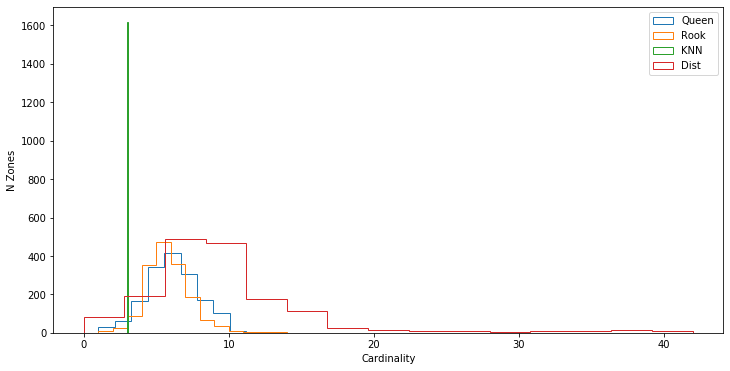

In [6]:
f, ax= plt.subplots(1,sharey=True)
f.set_size_inches(12,6)

W={'Queen':w_queen,'Rook':w_rook,'KNN':w_knn,'Dist':w_dist_1km}

for kw in W.keys():
    w=W[kw]
    print(kw,'==> Cardinalities, neighbors, weights:',w.cardinalities[100],w.neighbors[100],w.weights[100])
    card=pd.Series(w.cardinalities)
    ax.hist(card, bins=15,histtype='step',label=kw)
    
ax.set_xlabel('Cardinality')
ax.set_ylabel('N Zones')
ax.legend()

### ¿Cómo se ven las distintas matrices para un determinada zona (`NZONE=100`)?

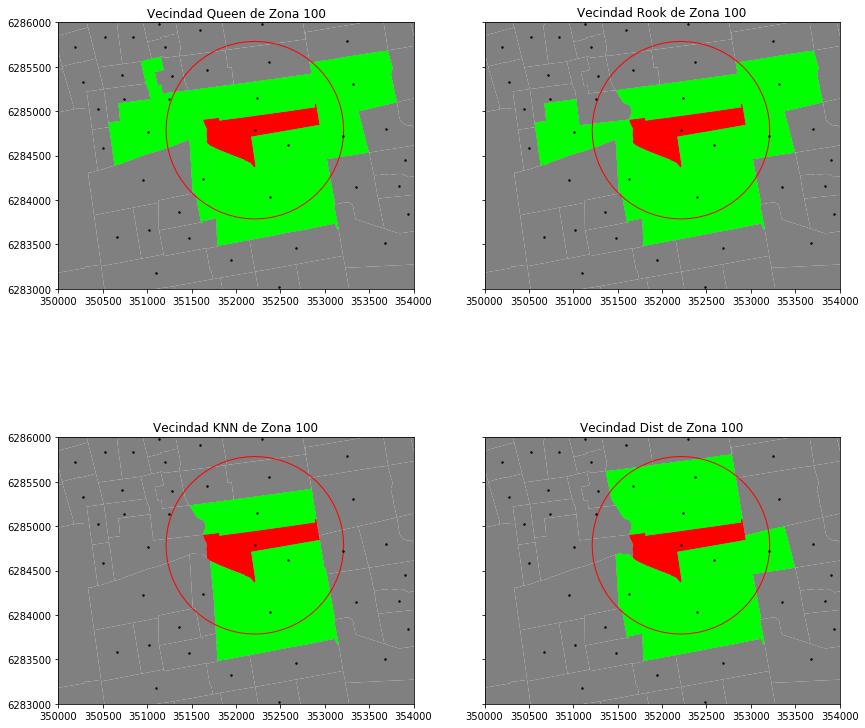

In [7]:
f,axes = plt.subplots(2,2,sharey=True)
f.set_size_inches(14,14)
axs=[axes[0][0],axes[0][1],axes[1][0],axes[1][1]]


focus = zona_diss.loc[[100], ['geometry']]

for ax in axs:
    zona_diss.plot(ax=ax, facecolor='gray', linewidth=0.1)
    focus.plot(facecolor='red', alpha=1, linewidth=0, ax=ax)
    ax.set_xlim(350000,354000)
    ax.set_ylim(6283000,6286000)
    
for kw,ax in zip(W.keys(),axs):
    w=W[kw]
    ax.set_title("Vecindad %s de Zona 100"%kw)
    
    #vecinos de la zona 100
    neis= zona_diss.loc[w[100], :]
    neis.plot(ax=ax, facecolor='lime', linewidth=0)
    
    #buffer de 1000 m alrededor de la zona 100
    buf = focus.centroid.buffer(1000)
    buf.plot(edgecolor='red', facecolor='none', ax=ax)
    zona_diss.centroid.plot(ax=ax, color='k',markersize=2)
    

## Lag espacial.

Es el producto de una matriz de peso espacial y la variable misma, donde $Y$ es un vector $Nx1$ con los valores de la variable:

$$ Y_{SL}=Y \cdot W $$

- En general es conveniente normalizar los pesos espaciales para remover efectos de escala (por ejemplo, unidades de distancia utilizadas). En general, se acostumbra normalizar la matriz $W$ fila: los pesos en cada fila son normalizados para sumar 1, de manera cada peso $w_{ij}$  puede ser interpretado como la fracción de toda la influencia espacial sobre $i$  atribuido a la unidad $j$.


- También es conveniente normalizar los valores de la variable antes de calcular su lag espacial, y reescalar de manera que su distribución tenga promedio 0 y desviación estándar 1.

$$ z_i=\frac{x_i-\bar{x}}{\sigma}$$

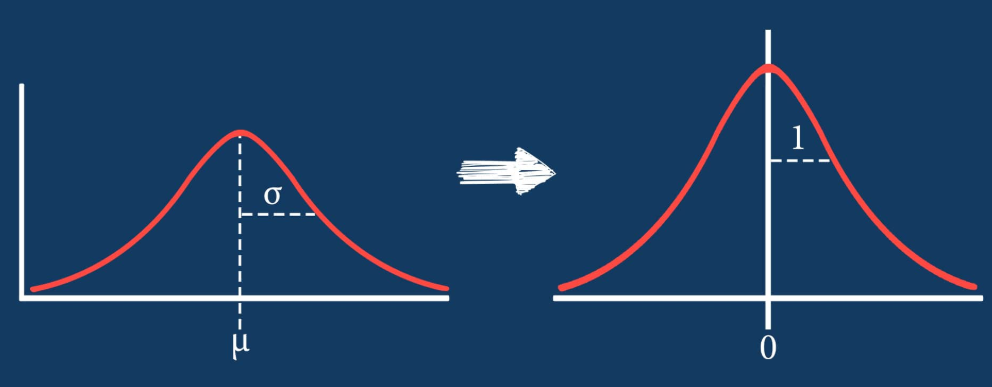


In [8]:
W={'Queen':w_queen,'Rook':w_rook,'KNN':w_knn,'Dist':w_dist_1km}

for kw,ax in zip(W.keys(),axs):
    
    # normalizacion por filas de la matriz W 
    w=W[kw]
    w.transform ='R'
    
    #normalizacion de la variable
    mean=np.mean(zona_diss[field_correl])
    std=np.std(zona_diss[field_correl])
    normed=(zona_diss[field_correl]-mean)/std
    
    #agrego la variable normalizada como columna al data frame
    
    zona_diss['%s_norm'%field_correl]=normed
    
    #calculo del lag espacial, se convierte a una serie y se agrega como columna adicional al data frame
    w_lag = pd.Series(weights.lag_spatial(w, normed),index=normed.index)
    zona_diss['slag_%s_%s'%(kw,field_correl)] = w_lag
   
print(zona_diss.columns)

('WARNING: ', 0, ' is an island (no neighbors)')
('WARNING: ', 1, ' is an island (no neighbors)')
('WARNING: ', 130, ' is an island (no neighbors)')
('WARNING: ', 158, ' is an island (no neighbors)')
('WARNING: ', 273, ' is an island (no neighbors)')
('WARNING: ', 281, ' is an island (no neighbors)')
('WARNING: ', 284, ' is an island (no neighbors)')
('WARNING: ', 627, ' is an island (no neighbors)')
('WARNING: ', 630, ' is an island (no neighbors)')
('WARNING: ', 636, ' is an island (no neighbors)')
('WARNING: ', 731, ' is an island (no neighbors)')
('WARNING: ', 732, ' is an island (no neighbors)')
('WARNING: ', 741, ' is an island (no neighbors)')
('WARNING: ', 745, ' is an island (no neighbors)')
('WARNING: ', 747, ' is an island (no neighbors)')
('WARNING: ', 749, ' is an island (no neighbors)')
('WARNING: ', 874, ' is an island (no neighbors)')
('WARNING: ', 894, ' is an island (no neighbors)')
('WARNING: ', 908, ' is an island (no neighbors)')
('WARNING: ', 1222, ' is an island 

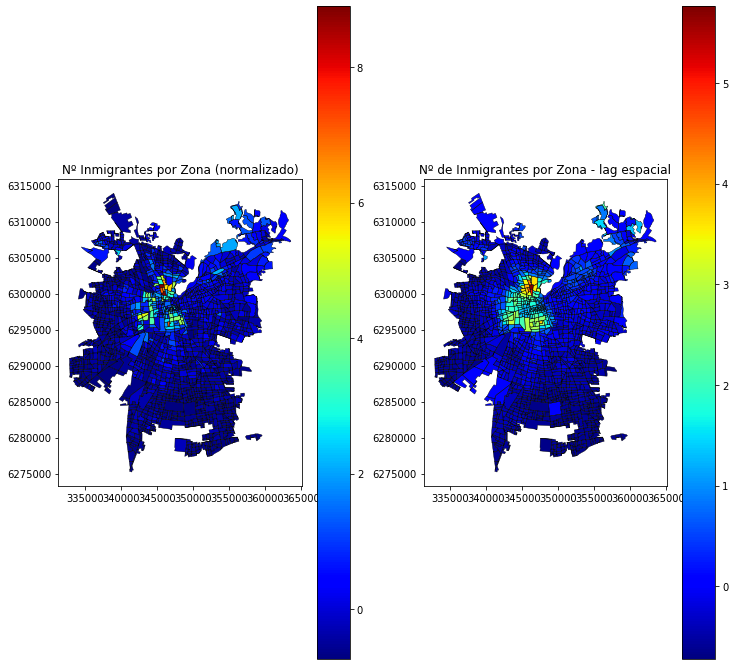

In [9]:
f, axes = plt.subplots(1,2, figsize=(12,12))
field_correl='INMIGRANTE'

im=zona_diss.plot(ax=axes[0], column='%s_norm'%field_correl,cmap='jet', linewidth=0.4,legend=True)
zona_diss.boundary.plot(ax=axes[0], color='black',linewidth=0.4,label='Zonas')
axes[0].set_title('Nº Inmigrantes por Zona (normalizado)')


zona_diss.plot(ax=axes[1], column='slag_Dist_INMIGRANTE',cmap='jet', linewidth=0.4,legend=True)
zona_diss.boundary.plot(ax=axes[1], color='black',linewidth=0.4,label='Zonas')
axes[1].set_title('Nº de Inmigrantes por Zona - lag espacial');

## Gráfico de Moran.

- Es una herramienta gráfica para explorar el concepto de autocorrelación espacial a nivel global.

- Consiste en un scatter plot en el cual una variable dada es graficada versus su propio lag espacial (valor promedio en el vecindario).

- El gráfico de Moran se puede resumir en una estadística global de autocorrelación espacial: el índice $I$ de Moran, calculado como la pendiente del fit lineal al gráfico de Moran.

La librería `esda`de PySAL provee herramietnas para calcular la estadística de Moran: https://pysal.org/esda/api.html




Slope: 0.6680004609409623
Slope: 0.6797658355698903
Slope: 0.6635549093964497
Slope: 0.6207387236924928


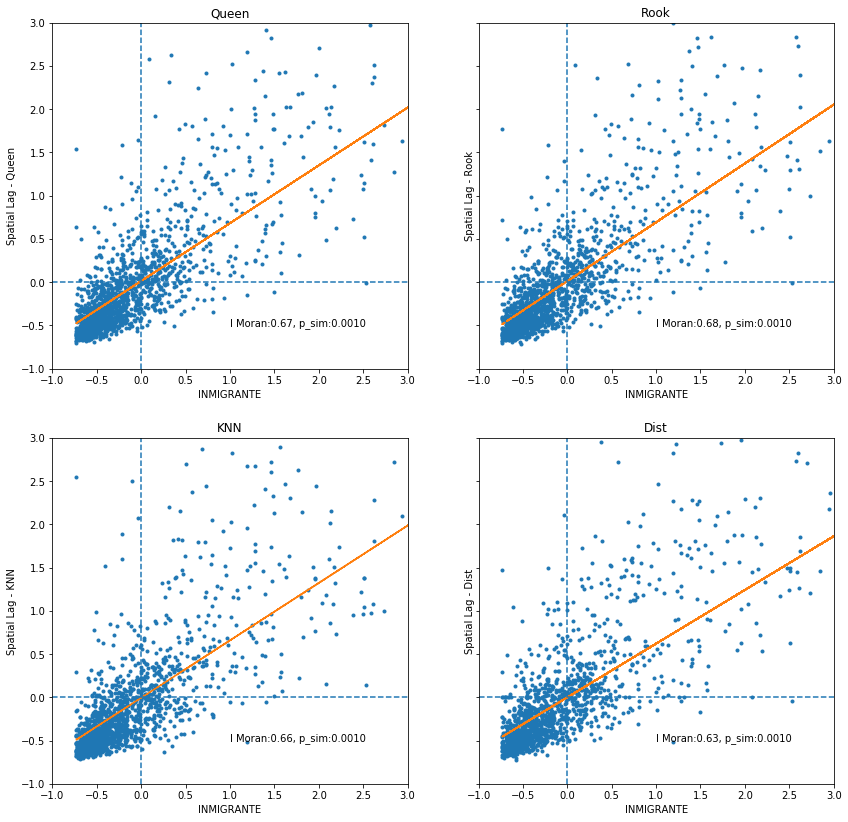

In [10]:
f,axes = plt.subplots(2,2,sharey=True)
f.set_size_inches(14,14)
axs=[axes[0][0],axes[0][1],axes[1][0],axes[1][1]]

for kw,ax in zip(W.keys(),axs):
    w=W[kw]
    x=zona_diss['%s_norm'%field_correl]
    y=zona_diss['slag_%s_%s'%(kw,field_correl)]
    
    m,b= np.polyfit(x, y, 1)
    print('Slope:',m)
    ax.plot(x,y,'.')
    ax.plot(x,m*x+b,ls='--')
    ax.set_xlabel(field_correl)
    ax.set_ylabel('Spatial Lag - %s' %kw)
    ax.set_xlim(-1,3)
    ax.set_ylim(-1,3)
    ax.set_title(kw)
    ax.axhline(y=0,ls='--')
    ax.axvline(x=0,ls='--')

    
    mi = esda.Moran(x, w)
    ax.text(1,-0.5,'I Moran:%.2f, p_sim:%.4f'%(mi.I,mi.p_sim))


## Significancia de la autocorrelación espacial.

Un resultado es estadísticamente significativo si permite rechazar la hipótesis nula de aleatoreidad espacial.

Es decir, ¿la distribución de valores sobre(bajo) la media, es distinto a los que esperaríamos si el proceso fuera totalmente aleatorio?

Una forma de verificar el nivel de significancia de $I$ es mediaten permutaciones espaciales aleatorias:  se calcula una distribución de referencia haciendo una (en verdad, muchas, ~1000) permutación aleatoria de los valores observados entre todas las ubicaciones.
Luego se calcula la estadística para todas las permutaciones y se obtiene una distribución de referencia.
Esta distribución se usa para cacular el valor $p$, de acuerdo a:

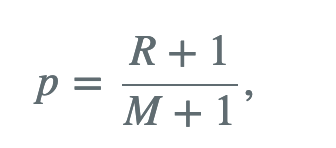

Donde:
- M: número de permutaciones
- R: número de veces que el I calculado para los datadets aleatorios es igual o mayor que el observado.

## Indicadores locales de autocorrelación espacial (LISA).

El índice de Moran indica el nivel de autocorrelación global del conjunto de datos.
En general, ¿hay un patrón espacial en los datos, o se trata de una distribución espacialmente aleatoria?

Si es que hay un patrón espacial, ¿cuáles son las unidades espaciales que están correlacionadas (positiva o negativamente) con sus vecinos? ¿dónde están los clusters? ¿qué áreas contribuyen más (o menos) a nuestra estadística global?

Para ello, utilizamos los indicadores de autocorrelación local (LISA).

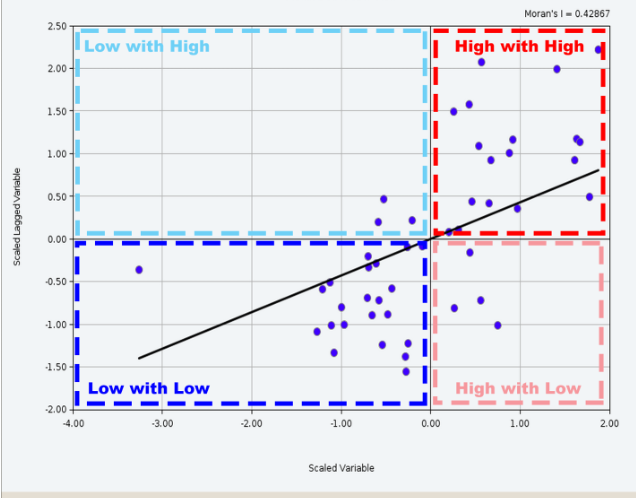

Slope: 0.6207387236924928


/Users/paguirre/anaconda3/lib/python3.6/site-packages/geopandas/geodataframe.py:576: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super(GeoDataFrame, self).__getitem__(key)


Text(0.5, 0.98, 'LISA para INMIGRANTE')

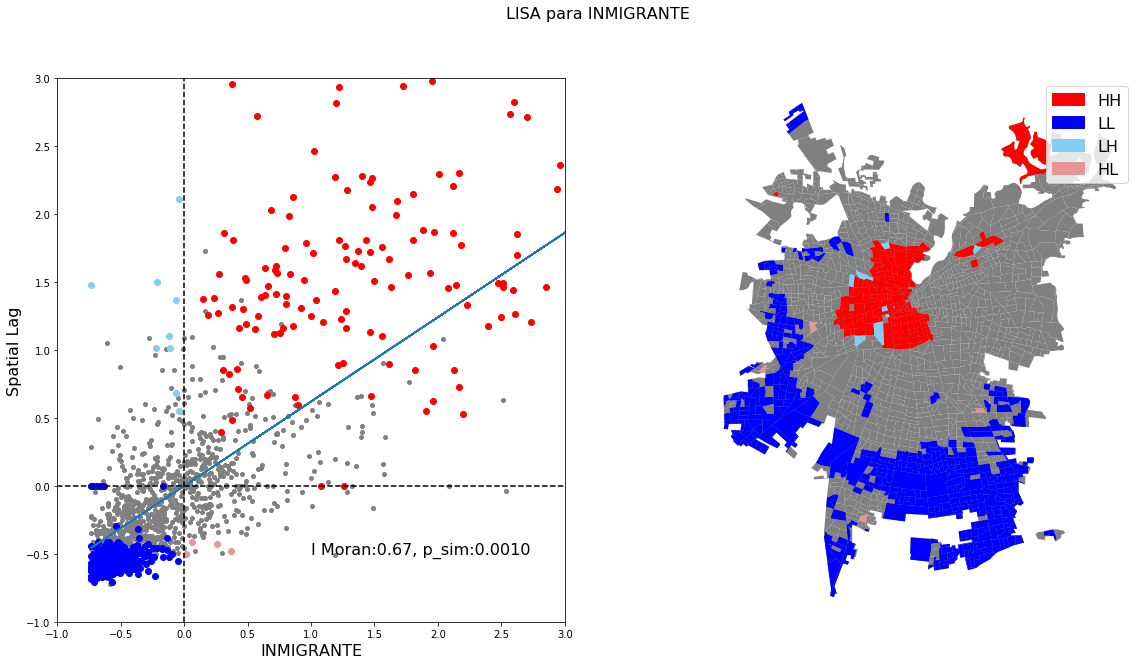

In [28]:
import matplotlib.patches as mpatches
w=W['Queen']
x=zona_diss['%s_norm'%field_correl]
y=zona_diss['slag_%s_%s'%(kw,field_correl)]

lisa = esda.Moran_Local(x, w)

zona_diss['quadrant'] = lisa.q
zona_diss['significant'] = lisa.p_sim < 0.05

quads={1:'HH',2:'LH',3:'LL',4:'HL'}

palette = {'LL': 'blue','HH':'red','LH':'#83cef4','HL':'#e59696'}
               
zona_diss['quad_class'] = [quads[x] for x in zona_diss['quadrant']]

HHm=(zona_diss['significant']) & (zona_diss['quadrant']==1) 
LLm=(zona_diss['significant']) & (zona_diss['quadrant']==3) 
HLm=(zona_diss['significant']) & (zona_diss['quadrant']==4) 
LHm=(zona_diss['significant']) & (zona_diss['quadrant']==2) 

f,(ax,ax2) = plt.subplots(1,2, figsize=(20, 10))

#Moran
m,b= np.polyfit(x, y, 1)
print('Slope:',m)
ax.plot(x,y,'o',color='gray',markersize=4)

ax.plot(x[HHm],y[HHm],'o',color='r',markersize=6)
ax.plot(x[LLm],y[LLm],'o',color='b',markersize=6)
ax.plot(x[LHm],y[LHm],'o',color='#83cef4',markersize=6)
ax.plot(x[HLm],y[HLm],'o',color='#e59696',markersize=6)

ax.plot(x,m*x+b,ls='--')
ax.set_xlabel(field_correl,fontsize=16)
ax.set_ylabel('Spatial Lag' ,fontsize=16)
ax.set_xlim(-1,3)
ax.set_ylim(-1,3)
ax.axhline(y=0,ls='--',color='k')
ax.axvline(x=0,ls='--',color='k')

    
mi = esda.Moran(x, w)
ax.text(1,-0.5,'I Moran:%.2f, p_sim:%.4f'%(mi.I,mi.p_sim),fontsize=16)

#mapa
sig=zona_diss[zona_diss['significant']]
zona_diss.plot(color='gray',ax=ax2)

datsig={'HH':HH[HHm],'LL':LL[LLm],'LH':LH[LHm],'HL':HL[HLm]}
handles=[]
for ctype in datsig.keys():
    data=datsig[ctype]
    # Definir color para cada grupo
    color = palette[ctype]
    
    # Graficar grupo en el color correspondiente y agregar a leyenda
    hand=data.plot(color=color,ax=ax2,label=ctype)
    handles.append(mpatches.Patch(color=color, label=ctype))

plt.legend(handles=handles,loc='best',fontsize=16)
ax2.set_axis_off()
f.suptitle('LISA para %s'%field_correl, size=16)


